In [276]:
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, roc_auc_score, roc_curve, auc

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

In [277]:
df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df.columns = ['_'.join([word.lower() for word in col_name.split(' ')]) for col_name in df.columns]
test_df.columns = ['_'.join([word.lower() for word in col_name.split(' ')]) for col_name in test_df.columns]

df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [279]:
df.isna().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [280]:
df.drop(columns=['passengerid'], inplace=True)
test_passengerid = test_df['passengerid']
test_df.drop(columns=['passengerid'], inplace=True)

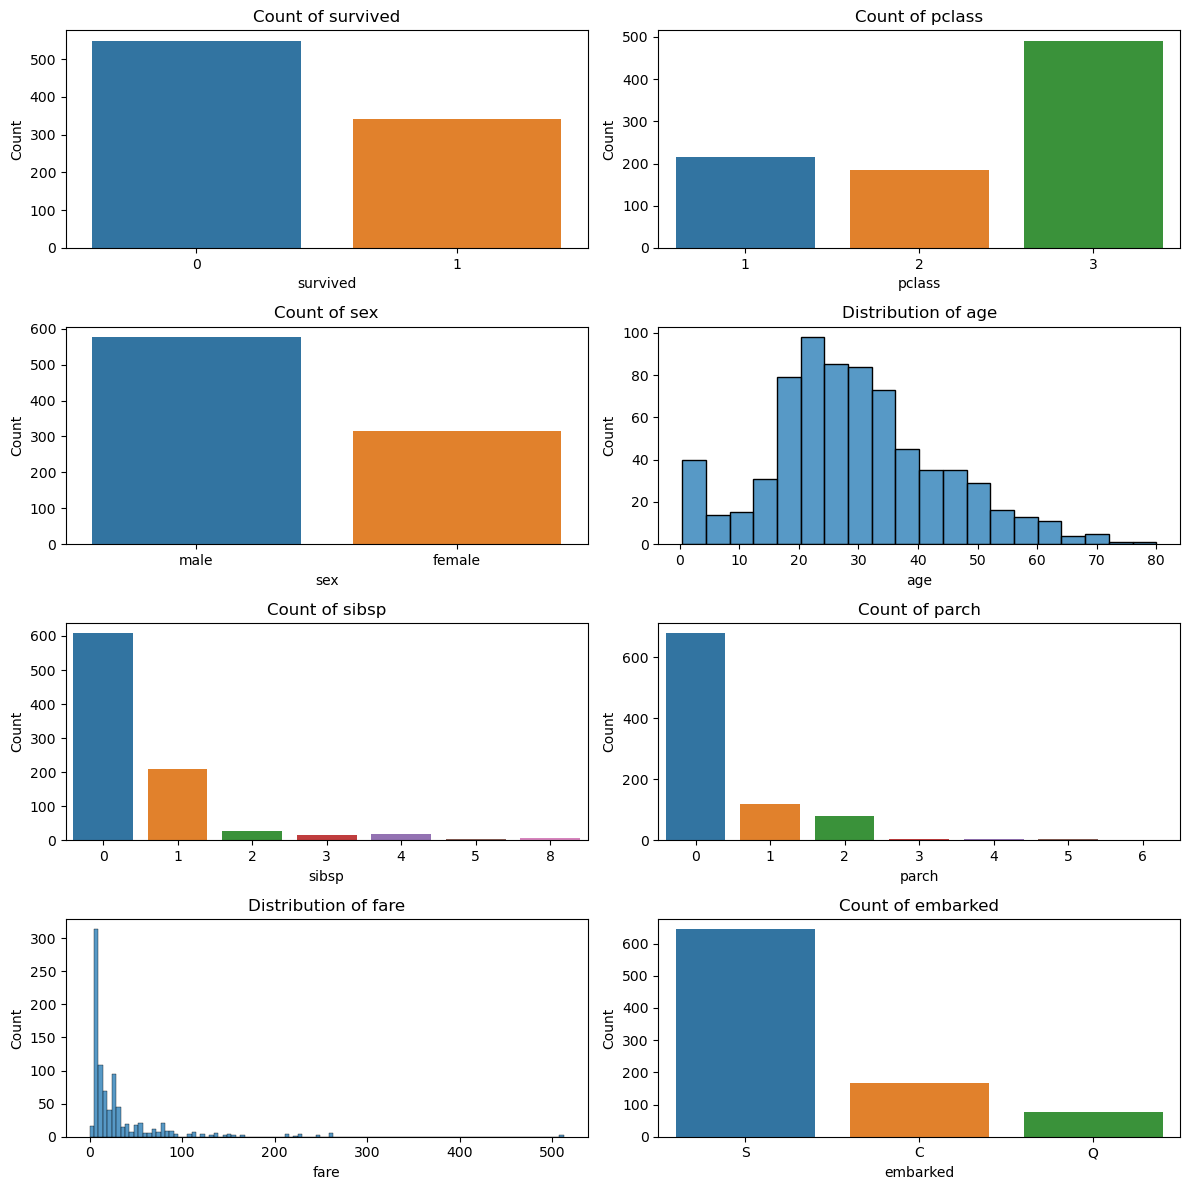

In [281]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axes = axes.flatten()

i = 0
for col in df.columns:
    if col not in ['name', 'ticket', 'cabin']:
        if len(df[col].unique()) < 10:
            sns.countplot(x=col, data=df, ax=axes[i])
            axes[i].set_title(f"Count of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
        else:
            sns.histplot(df[col], ax=axes[i])
            axes[i].set_title(f"Distribution of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
        i += 1

plt.tight_layout()
plt.show()

Построим теперь теже самые графики, только для тестовой выборки и сравним

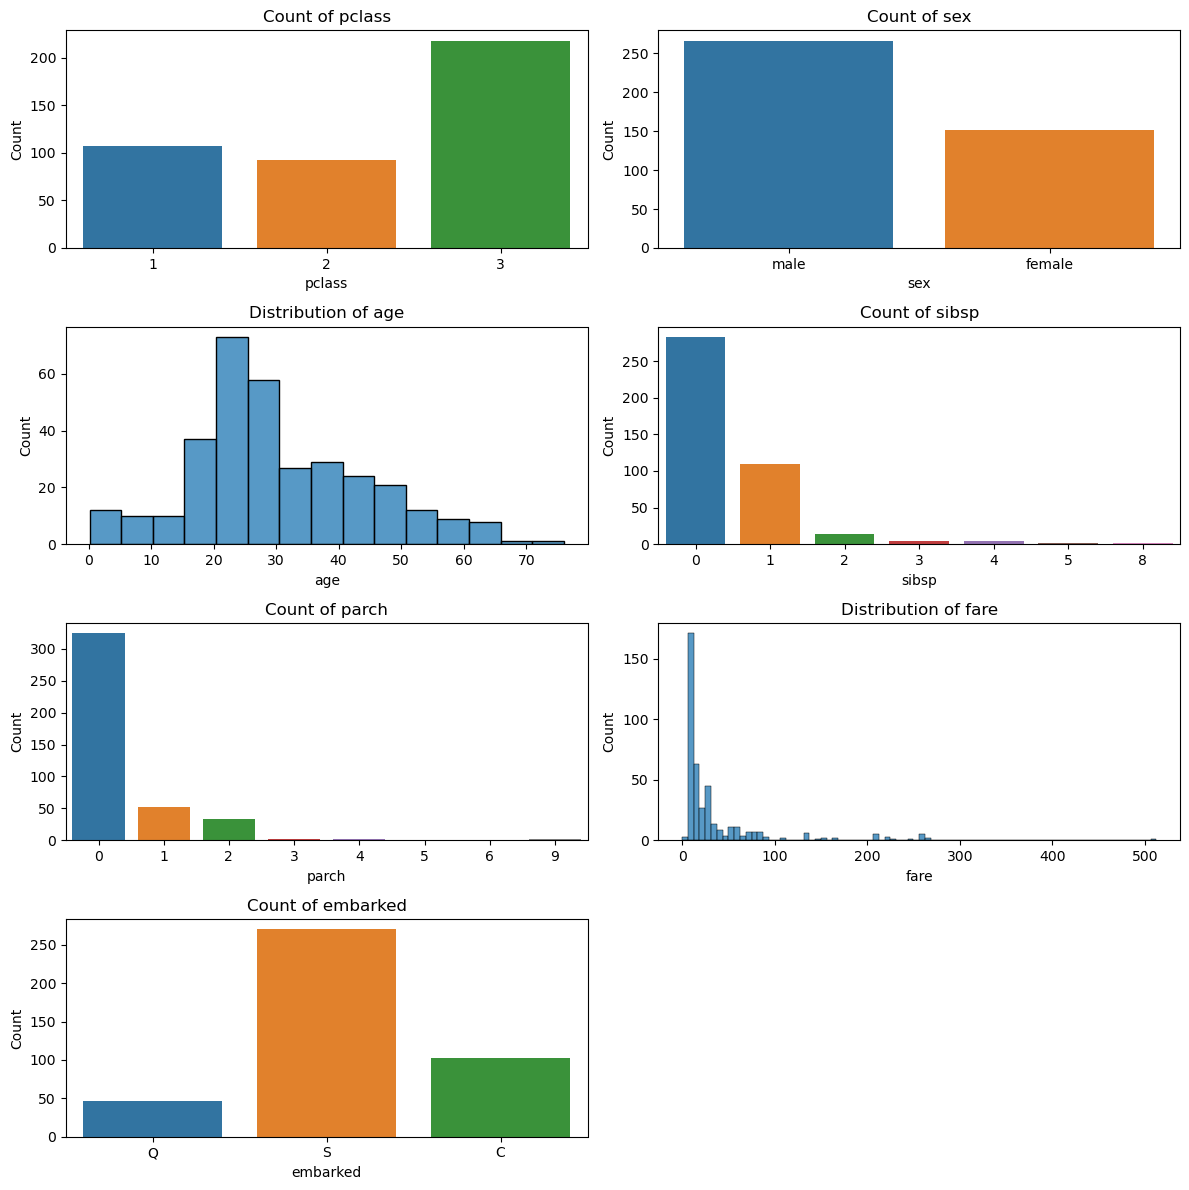

In [282]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))
axes = axes.flatten()

i = 0
for col in test_df.columns:
    if col not in ['name', 'ticket', 'cabin']:
        if len(test_df[col].unique()) < 10:
            sns.countplot(x=col, data=test_df, ax=axes[i])
            axes[i].set_title(f"Count of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
        else:
            sns.histplot(test_df[col], ax=axes[i])
            axes[i].set_title(f"Distribution of {col}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Count")
        i += 1

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Видно, что данные на тестовой выборке распределены похоже на тренировочную выборку

На графиках видно, что некоторые значения fare равны 0, что скорее всего является пропуском. Заменим их на медиану по классу

In [283]:
# Заменим значения в fare = 0 на медиану по классу

df['fare'] = df.groupby('pclass')['fare'].transform(lambda x: x.replace(0, x.median()))
test_df['fare'] = test_df.groupby('pclass')['fare'].transform(lambda x: x.replace(0, x.median()))
test_df['fare'].fillna(test_df[(test_df['fare'].notna()) & test_df['pclass'] == 3].median())

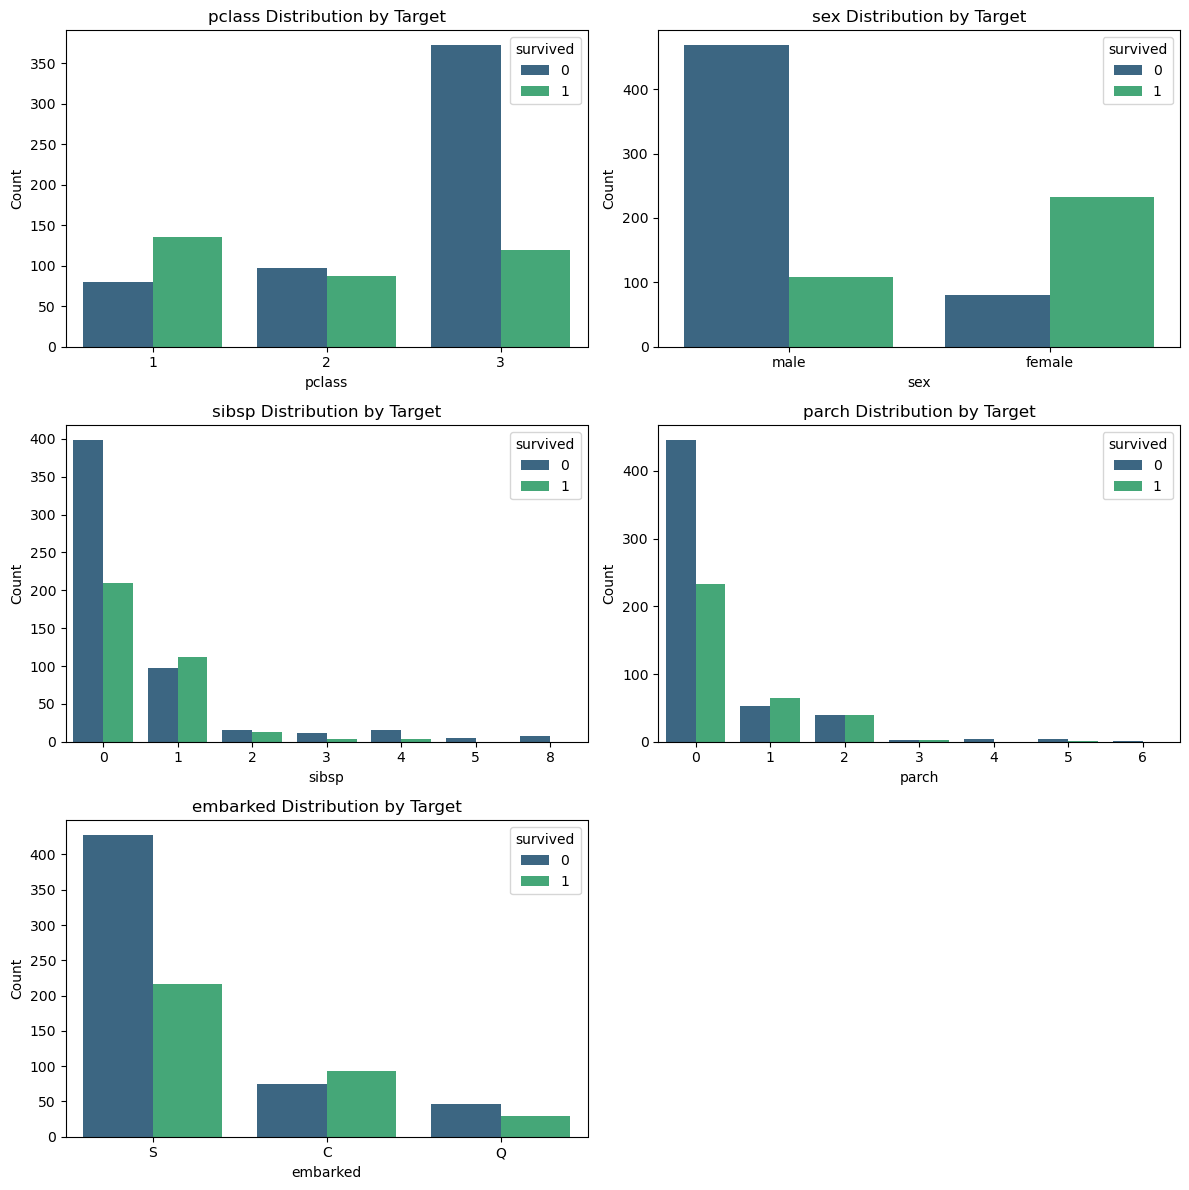

In [284]:
features_to_visualize = [df.columns[i] for i in range(1, len(df.columns)) if len(df[df.columns[i]].unique()) < 10 and df.columns[i] not in ['survived']]
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for ax, feature in zip(axs.flatten(), features_to_visualize):
    sns.countplot(data=df, x=feature, hue='survived', palette='viridis', ax=ax)
    ax.set_title(f'{feature} Distribution by Target')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='survived')

fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

По последнему графику вижно, что в зависимости от порта отправления просматривается зависимость выживаемости. Но я считаю, что это скорее связано с распределением пассажиров разных классов между этими портами, давайте проверим

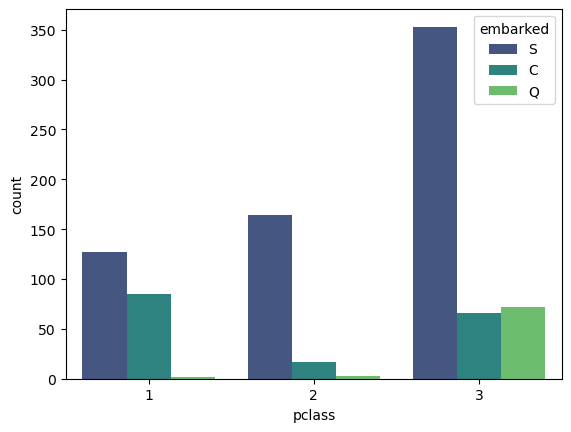

In [285]:
sns.countplot(data=df, x='pclass', hue='embarked', palette='viridis')
ax.set_title(f'pclass Distribution by embarked')
ax.set_xlabel('pclass')
ax.set_ylabel('Count')
ax.legend(title='embarked')
plt.show()

Из данного графика видно, что наше предположение было верным

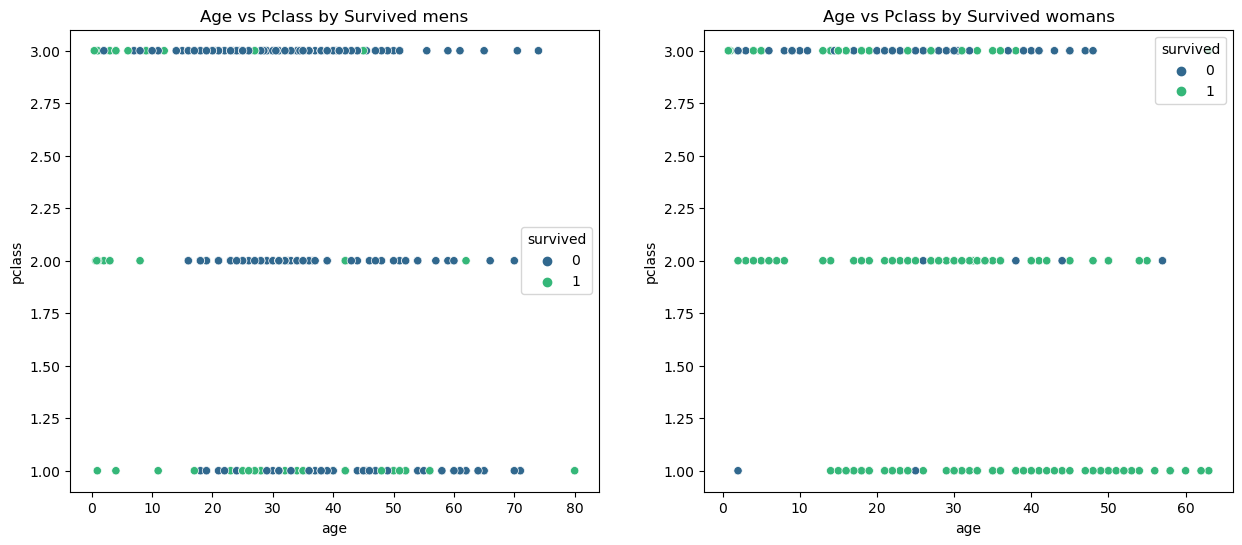

In [286]:
# Посстроим график в координатах возраст и класс билета, где разным цветом будем обозначать выживших и погибших

mens = df[df['sex'] == 'male']
womans = df[df['sex'] == 'female']

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.scatterplot(data=mens, x='age', y='pclass', hue='survived', palette='viridis', ax=axs[0])
axs[0].set_title('Age vs Pclass by Survived mens')
sns.scatterplot(data=womans, x='age', y='pclass', hue='survived', palette='viridis', ax=axs[1])
axs[1].set_title('Age vs Pclass by Survived womans')
plt.show()

Из графиков видно, что почти все женщины из первого и второго класса выжили, а из третьего класса - нет. Поэтому добавим новую фичу - женщина из первого или второго класса под названием wom

In [287]:
# добавим новую фичу - женщина из первого или второго класса
df['is_rich_woman'] = ((df['sex'] == 'female') & (df['pclass'] < 3)).astype(int)
test_df['is_rich_woman'] = ((test_df['sex'] == 'female') & (test_df['pclass'] < 3)).astype(int)

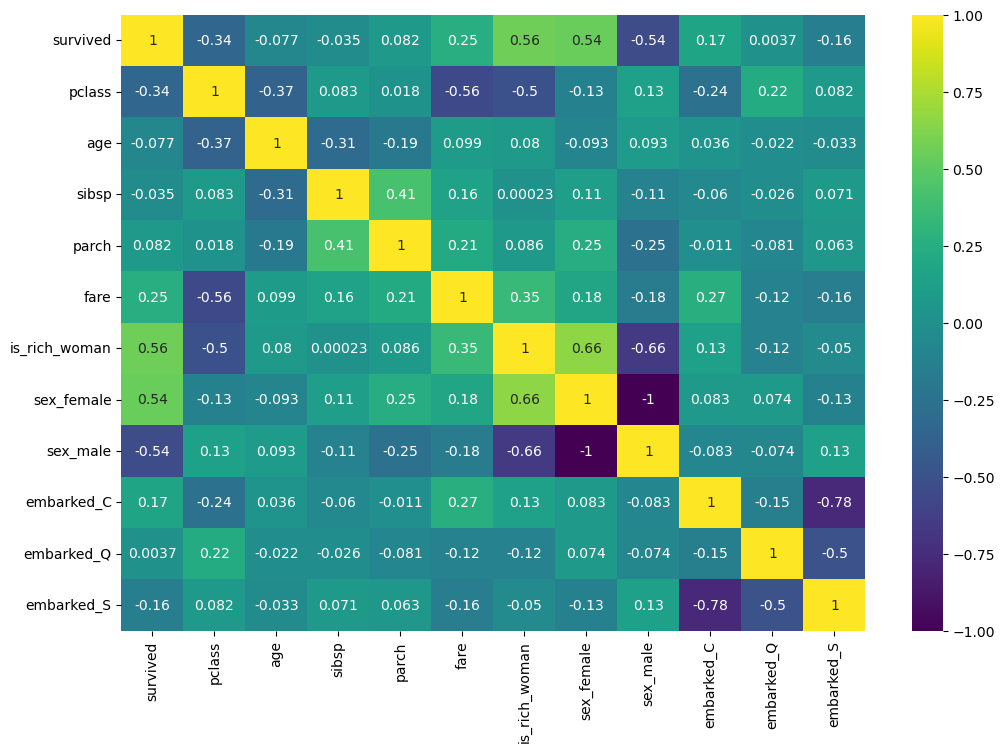

In [288]:
# построим график корреляции

plt.figure(figsize=(12, 8))
df_encoded = pd.get_dummies(df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'is_rich_woman']])
sns.heatmap(df_encoded.corr(), annot=True, cmap='viridis')
plt.show()

Начнем заполнять пропуски. В колонке embarked одно пропущенное замени его наиболее популярным значением 'S' из этого класса. В колонке age заменим пропущенные значения на предсказанные с помощью rf

In [289]:
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)
test_df['embarked'].fillna(test_df['embarked'].mode()[0], inplace=True)

In [290]:
test_age = df[df['age'].isna()]
train_age = df[df['age'].notna()]

X = train_age[['pclass', 'sibsp', 'parch', 'fare']]
y = train_age['age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X_train, y_train)
pred_median = [y_train.median()] * y_test.shape[0]
print(f"MAE и MSE при подставлении медианы {mean_absolute_error(y_test, pred_median)} {mean_squared_error(y_test, pred_median)}")

pred_rf = model.predict(X_test)
print(f"MAE и MSE при испольщовании rf {mean_absolute_error(y_test, pred_rf)} {mean_squared_error(y_test, pred_rf)}")

MAE и MSE при подставлении медианы 10.804195804195805 185.4090909090909
MAE и MSE при испольщовании rf 9.242458730471526 135.229619901087


Видно что при использовании rf ошибка меньше, чем при подставлении медианы

In [ ]:
model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X, y)
predicted_ages = model.predict(test_age[['pclass', 'sibsp', 'parch', 'fare']]).astype(int)
df.loc[df['age'].isna(), 'age'] = predicted_ages

Сделаем тоже самое для тестовых данных

In [ ]:
test_age = test_df[test_df['age'].isna()]
train_age = test_df[test_df['age'].notna()]

X = train_age[['pclass', 'sibsp', 'parch', 'fare']]
y = train_age['age']

model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
model.fit(X, y)
predicted_ages = model.predict(test_age[['pclass', 'sibsp', 'parch', 'fare']]).astype(int)
test_df.loc[test_df['age'].isna(), 'age'] = predicted_ages

Заметим, что в колонке cabin очень много пропущенных значений, посмотрим на процент выживших с пропущенным значеним в cabin и нет

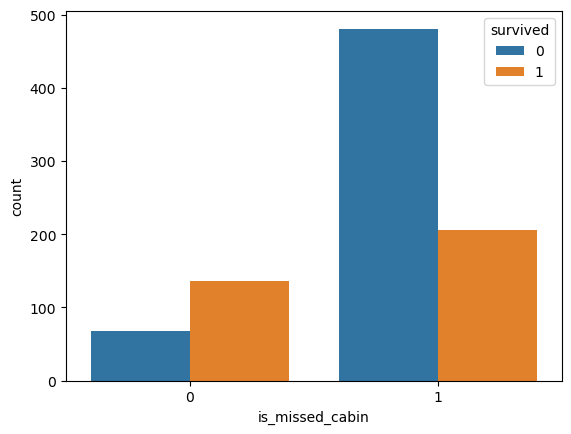

In [ ]:
# посмотрим на процент выживших с пропущенным значеним в cabin и нет

df['is_missed_cabin'] = df['cabin'].isna().astype(int)
test_df['is_missed_cabin'] = test_df['cabin'].isna().astype(int)
sns.countplot(data=df, x='is_missed_cabin', hue='survived')
plt.show()

Заметим, что с пропущенным значеним в cabin выживших меньше, чем с заполненным значением. Рассмотрим строки с пропусками более подробно. Построим графики зависимости выживаемости от пропущенных значений у мужчин и женщин

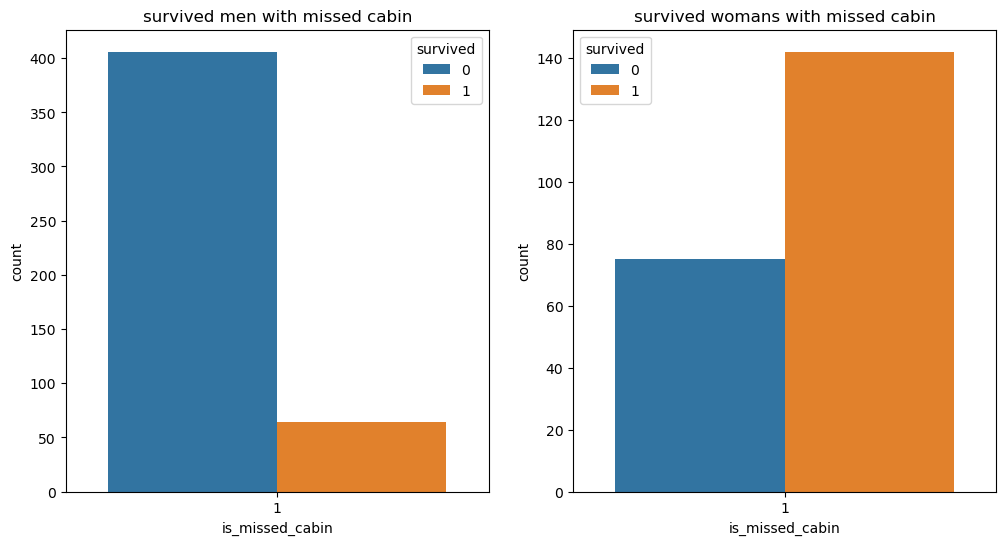

In [ ]:
# Построим графики зависимости выживаемости от пропущенных значений у мужчин и женщин

missed_cabin_male = df[(df['sex'] == 'male') & (df['cabin'].isna())]
missed_cabin_female = df[(df['sex'] == 'female') & (df['cabin'].isna())]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.countplot(data=missed_cabin_male, x='is_missed_cabin', hue='survived', ax=axs[0])
axs[0].set_title(f"survived men with missed cabin")
sns.countplot(data=missed_cabin_female, x='is_missed_cabin', hue='survived', ax=axs[1])
axs[1].set_title(f"survived womans with missed cabin")
plt.show()

Из графиков видно, что пропущенные значения в cabin в основом у мужчин и у них выживаемость меньше, чем у женщин. Поэтому добавим новую фичу is_missed_cabin

In [ ]:
# добавим еще несколько новых фичей

def add_new_features(df):
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['isalone'] = df['family_size'].apply(lambda x: 1 if x == 1 else 0)
    df['farebin'] = pd.qcut(df['fare'], 4, labels=False)
    df['agebin'] = pd.cut(df['age'].astype(int), 5, labels=False)
    df['title'] = df['name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    df['title'] = df['title'].apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'Other')
    return df

df = add_new_features(df)
test_df = add_new_features(test_df)

In [ ]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,is_rich_woman,is_missed_cabin,family_size,isalone,farebin,agebin,title
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1,2,0,0,1,Mr
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,2,0,3,2,Mrs
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,1,1,0,1,Miss
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,2,0,3,2,Mrs
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1,1,1,1,2,Mr


Начнем обучение модели, рассмотрим только rf и catboost

In [ ]:
df.drop(columns=['name', 'ticket', 'cabin'], inplace=True)
test_df.drop(columns=['name', 'ticket', 'cabin'], inplace=True)

In [ ]:
df['sex'] = df['sex'].astype('category')
df['embarked'] = df['embarked'].astype('category')
df['title'] = df['title'].astype('category')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['survived']), df['survived'], test_size=0.3, random_state=42)

In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        cat_features=['sex', 'embarked', 'title'],
        iterations=trial.suggest_int("iterations", 500, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 2, 4),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False,
        task_type='CPU'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

bohb_sampler = optuna.samplers.TPESampler(n_startup_trials=70, n_ei_candidates=13, multivariate=True)
study = optuna.create_study(sampler=bohb_sampler, direction='maximize')
study.optimize(objective, n_trials=300, show_progress_bar=True, n_jobs=-1)

In [ ]:
study.best_params

In [ ]:
df['sex'] = df['sex'].astype('object')
df['embarked'] = df['embarked'].astype('object')
df['title'] = df['title'].astype('object')

In [ ]:
df_dummies = pd.get_dummies(df)
X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop(columns=['survived']), df_dummies['survived'], test_size=0.3, random_state=42)

In [ ]:
def objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("iterations", 500, 1000),
        max_depth=trial.suggest_int("depth", 5, 15),
        criterion=trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

bohb_sampler = optuna.samplers.TPESampler(n_startup_trials=70, n_ei_candidates=13, multivariate=True)
study_rf = optuna.create_study(sampler=bohb_sampler, direction='maximize')
study_rf.optimize(objective, n_trials=300, show_progress_bar=True, n_jobs=-1)

catboost показал качество лучше, чем rf поэтому используем его

In [ ]:
test_df['sex'] = test_df['sex'].astype('category')
test_df['embarked'] = test_df['embarked'].astype('category')
test_df['title'] = test_df['title'].astype('category')

In [ ]:
model = CatBoostClassifier(**study.best_params, cat_features=['sex', 'embarked', 'title'], verbose=False)
model.fit(df.drop(columns=['survived']), df['survived'])
pred = model.predict(test_df)

In [ ]:
test_df['PassengerId'] = test_passengerid
test_df['Survived'] = pred
test_df[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)